# Pre-process POP909 for Polyphemus
- split 909 into phrases instead of bars
- Phrases are of varying bar-length --> Add padding??
- Use 4/4 only

In [1]:
import re
import os
import time
import sys
import multiprocessing
import itertools
import argparse
from itertools import product

import numpy as np
from tqdm import tqdm
import pypianoroll as pproll
import muspy

In [2]:
midi_folder = "POP909"
structure_folder = "POP909_structure"

In [3]:
from preprocess_pop909 import *

In [4]:
midi_dataset_dir = "POP909"
structure_dir = "POP909_structure"
song_idx = "001"
dest_dir = "preprocessed_909_mask"
n_bars = 8
resolution = 8

In [5]:
preprocess_midi_file(midi_dataset_dir, song_idx, structure_dir, dest_dir, n_bars, resolution)

Song accepted! POP909/001/001.mid with time signature 2/4
saved to preprocessed_909_mask/001.mid0
saved to preprocessed_909_mask/001.mid1
saved to preprocessed_909_mask/001.mid2


## Debug

In [59]:
filepath = "POP909/001/001.mid"
structure_path = "POP909_structure/001/human_label1.txt"

In [60]:
pproll_song = pproll.read(filepath, resolution=8)
muspy_song = muspy.read(filepath)

In [61]:
f = open(f"{structure_path}", "r")
structure = f.read()
phrases = split_string(structure)

In [62]:
phrases

['i4',
 'A4',
 'B8',
 'A4',
 'A4',
 'b4',
 'B8',
 'A4',
 'A4',
 'b4',
 'b4',
 'A4',
 'A4',
 'b4',
 'A4',
 'o3']

In [63]:
len(phrases)

16

In [64]:
phrase_songs = split_song_into_phrases(pproll_song, phrases, resolution)

In [65]:
phrase_songs[1][0]

Music(metadata=Metadata(schema_version='0.1'), resolution=8, tracks=[Track(program=0, is_drum=False, name='MELODY', notes=[Note(time=165, pitch=66, duration=2, velocity=64), Note(time=169, pitch=63, duration=2, velocity=64), Note(time=173, pitch=68, duration=11, velocity=64), ...]), Track(program=0, is_drum=False, name='BRIDGE', notes=[Note(time=133, pitch=66, duration=2, velocity=64), Note(time=137, pitch=75, duration=2, velocity=64), Note(time=141, pitch=73, duration=13, velocity=64), ...]), Track(program=0, is_drum=False, name='PIANO', notes=[Note(time=129, pitch=42, duration=14, velocity=64), Note(time=131, pitch=49, duration=11, velocity=64), Note(time=133, pitch=54, duration=9, velocity=64), ...])])

In [67]:
tracks_notes = [track.notes for track in phrase_songs[-1][0].tracks]

In [68]:
max_phrase_len_res = 4*resolution*constants.MAX_PHRASE_LEN
max_phrase_len_res

256

In [69]:
first_note//(resolution*4)

16

In [73]:
tracks_content = []
tracks_structure = []
phrase_len=3

print(tracks_notes)
first_note = np.inf
for notes in tracks_notes:
    track_first_note = min(note.time for note in notes) if notes else np.inf
    first_note = min(first_note, track_first_note)

# Calculate time offset from first note (ASSUME first note is in first bar)
print(first_note)
t_offset = (first_note//(resolution*4)) * resolution*4
print(t_offset)

for notes in tracks_notes:

    # track_content: length x MAX_SIMU_TOKENS x 2
    # This is used as a basis to build the final content tensors for
    # each sequence.
    # The last dimension contains pitches and durations. int16 is enough
    # to encode small to medium duration values.
    track_content = np.zeros((max_phrase_len_res, constants.MAX_SIMU_TOKENS, 2), 
                            np.int16)

    track_content[:, :, 0] = PitchToken.PAD.value
    track_content[:, 0, 0] = PitchToken.SOS.value
    track_content[:, :, 1] = DurationToken.PAD.value
    track_content[:, 0, 1] = DurationToken.SOS.value

    # Keeps track of how many notes have been stored in each timestep
    # (int8 imposes MAX_SIMU_TOKENS < 256)
    notes_counter = np.ones(max_phrase_len_res, dtype=np.int8)
    # print(notes_counter)

    # t_offset = None

    # Todo: np.put_along_axis?
    for note in notes:
        # Insert note in the lowest position available in the timestep
        # if t_offset is None:
        #     # print((note.time//resolution*4))
        #     t_offset = (note.time//(resolution*4)) * resolution*4
        # print(t_offset)
            
        t = note.time - t_offset
        print(t)

        if notes_counter[t] >= constants.MAX_SIMU_TOKENS-1:
            # Skip note if there is no more space
            # print(f"skipping note: {note}")
            continue
            
        pitch = max(min(note.pitch, constants.MAX_PITCH_TOKEN), 0)
        track_content[t, notes_counter[t], 0] = pitch
        dur = max(min(note.duration, constants.MAX_DUR_TOKEN + 1), 1)
        track_content[t, notes_counter[t], 1] = dur-1
        notes_counter[t] += 1
        # print(f"counting note: {notes_counter[t]}")
    # print(f"num notes: {notes_counter}")
    # Add EOS token
    t_range = np.arange(0, max_phrase_len_res)
    track_content[t_range, notes_counter, 0] = PitchToken.EOS.value
    track_content[t_range, notes_counter, 1] = DurationToken.EOS.value

    # Get track activations, a boolean tensor indicating whether notes
    # are being played in a timestep (sustain does not count)
    # (needed for graph rep.)
    activations = np.array(notes_counter-1, dtype=bool).astype(int)
    # print(np.array(notes_counter-1, dtype=bool))
    # Mask activations
    activations[4*resolution*phrase_len:] = constants.STRUCTURE_PAD
    # print(f"Padding after {phrase_len} bars: {activations}")

    tracks_content.append(track_content)
    tracks_structure.append(activations)

[[], [Note(time=2205, pitch=66, duration=3, velocity=64), Note(time=2209, pitch=75, duration=3, velocity=64), Note(time=2213, pitch=73, duration=1, velocity=64), Note(time=2217, pitch=71, duration=2, velocity=64), Note(time=2221, pitch=80, duration=1, velocity=64), Note(time=2223, pitch=82, duration=1, velocity=64), Note(time=2225, pitch=80, duration=9, velocity=64), Note(time=2237, pitch=66, duration=2, velocity=64), Note(time=2241, pitch=75, duration=3, velocity=64), Note(time=2245, pitch=73, duration=5, velocity=64), Note(time=2253, pitch=70, duration=12, velocity=64), Note(time=2269, pitch=73, duration=2, velocity=64)], [Note(time=2177, pitch=42, duration=28, velocity=64), Note(time=2177, pitch=54, duration=5, velocity=64), Note(time=2177, pitch=58, duration=4, velocity=64), Note(time=2181, pitch=49, duration=4, velocity=64), Note(time=2185, pitch=58, duration=4, velocity=64), Note(time=2185, pitch=61, duration=4, velocity=64), Note(time=2189, pitch=49, duration=5, velocity=64), No

In [26]:
for phrase_song, phrase_len in phrase_songs:

    tracks_notes = [track.notes for track in phrase_song.tracks]
    c_tensor, s_tensor = process_track_notes(tracks_notes, resolution, phrase_len)
    print(phrase_len, s_tensor)

4 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
  0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
  0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2

In [16]:
tracks_notes

[[Note(time=165, pitch=66, duration=2, velocity=64),
  Note(time=169, pitch=63, duration=2, velocity=64),
  Note(time=173, pitch=68, duration=11, velocity=64),
  Note(time=193, pitch=68, duration=2, velocity=64),
  Note(time=197, pitch=65, duration=1, velocity=64),
  Note(time=201, pitch=61, duration=1, velocity=64),
  Note(time=205, pitch=66, duration=8, velocity=64),
  Note(time=229, pitch=66, duration=2, velocity=64),
  Note(time=233, pitch=63, duration=1, velocity=64),
  Note(time=237, pitch=68, duration=5, velocity=64),
  Note(time=245, pitch=61, duration=1, velocity=64),
  Note(time=249, pitch=68, duration=1, velocity=64),
  Note(time=253, pitch=66, duration=14, velocity=64)],
 [Note(time=133, pitch=66, duration=2, velocity=64),
  Note(time=137, pitch=75, duration=2, velocity=64),
  Note(time=141, pitch=73, duration=13, velocity=64),
  Note(time=167, pitch=82, duration=1, velocity=64),
  Note(time=185, pitch=80, duration=2, velocity=64),
  Note(time=213, pitch=82, duration=2, vel

In [17]:
first_note = max_phrase_len_res
for notes in tracks_notes:
    track_first_note = min(note.time for note in notes) if notes else max_phrase_len_res
    first_note = min(first_note, track_first_note)

In [18]:
t_offset = (first_note//(resolution*4)) * resolution*4
t_offset

128

In [56]:
tracks_notes = [track.notes for track in muspy_song.tracks]

# Obtain length of subsong (maximum of each track's length)
length = 0
for notes in tracks_notes:
    track_length = max(note.end for note in notes) if notes else 0
    length = max(length, track_length)
length += 1

In [57]:
length

134562

In [58]:
resolution=8
# Add timesteps until length is a multiple of resolution
length = length if length % (4*resolution) == 0 \
    else length + (4*resolution-(length % (4*resolution)))

In [59]:
length

134592

In [23]:
muspy_song.tracks[0].notes[0]

Note(time=9160, pitch=61, duration=69, velocity=115)

In [15]:
pproll_song

Multitrack(name=None, resolution=8, tempo=array(shape=(7080, 1), dtype=float64), downbeat=array(shape=(2360, 1), dtype=bool), tracks=[StandardTrack(name='MELODY', program=0, is_drum=False, pianoroll=array(shape=(2360, 128), dtype=uint8)), StandardTrack(name='BRIDGE', program=0, is_drum=False, pianoroll=array(shape=(2360, 128), dtype=uint8)), StandardTrack(name='PIANO', program=0, is_drum=False, pianoroll=array(shape=(2360, 128), dtype=uint8))])

In [16]:
pproll_song.tracks

[StandardTrack(name='MELODY', program=0, is_drum=False, pianoroll=array(shape=(3792, 128), dtype=uint8)),
 StandardTrack(name='BRIDGE', program=0, is_drum=False, pianoroll=array(shape=(3792, 128), dtype=uint8)),
 StandardTrack(name='PIANO', program=0, is_drum=False, pianoroll=array(shape=(3792, 128), dtype=uint8))]

In [4]:
import torch

In [140]:
!ls preprocessed_909_4

001.mid0.npz   215.mid12.npz  420.mid14.npz  598.mid0.npz   753.mid5.npz
001.mid10.npz  215.mid13.npz  420.mid15.npz  598.mid10.npz  753.mid6.npz
001.mid1.npz   215.mid14.npz  420.mid16.npz  598.mid11.npz  753.mid7.npz
001.mid2.npz   215.mid15.npz  420.mid17.npz  598.mid12.npz  753.mid8.npz
001.mid3.npz   215.mid16.npz  420.mid18.npz  598.mid13.npz  753.mid9.npz
001.mid4.npz   215.mid17.npz  420.mid1.npz   598.mid14.npz  754.mid0.npz
001.mid5.npz   215.mid18.npz  420.mid2.npz   598.mid15.npz  754.mid10.npz
001.mid6.npz   215.mid19.npz  420.mid3.npz   598.mid1.npz   754.mid11.npz
001.mid7.npz   215.mid1.npz   420.mid4.npz   598.mid2.npz   754.mid12.npz
001.mid8.npz   215.mid2.npz   420.mid5.npz   598.mid3.npz   754.mid13.npz
001.mid9.npz   215.mid3.npz   420.mid6.npz   598.mid4.npz   754.mid14.npz
002.mid0.npz   215.mid4.npz   420.mid7.npz   598.mid5.npz   754.mid1.npz
002.mid1.npz   215.mid5.npz   420.mid8.npz   598.mid6.npz   754.mid2.npz
002.mid2.npz   215.mid6.npz   420.mid9.npz   5

In [155]:
len(os.listdir("preprocessed_909_4"))

7274

In [183]:
sample_path = os.path.join("preprocessed_909_4", "757.mid1.npz")
data = np.load(sample_path)
c_tensor = torch.tensor(data["c_tensor"], dtype=torch.long)
s_tensor = torch.tensor(data["s_tensor"], dtype=torch.int)

In [158]:
s_tensor

tensor([[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [79]:
c_tensor.shape

torch.Size([3, 256, 16, 2])

In [80]:
s_tensor.shape

torch.Size([3, 256])

In [81]:
bars = s_tensor.numpy().reshape(s_tensor.numpy().shape[0], 8, -1)
bars_acts = np.any(bars, axis=2)
np.diff(np.where(bars_acts == 0)[1])

array([3])

In [184]:
c_tensor

tensor([[[[128,  96],
          [129,  97],
          [130,  98],
          ...,
          [130,  98],
          [130,  98],
          [130,  98]],

         [[128,  96],
          [ 55,   2],
          [129,  97],
          ...,
          [130,  98],
          [130,  98],
          [130,  98]],

         [[128,  96],
          [129,  97],
          [130,  98],
          ...,
          [130,  98],
          [130,  98],
          [130,  98]],

         ...,

         [[128,  96],
          [129,  97],
          [130,  98],
          ...,
          [130,  98],
          [130,  98],
          [130,  98]],

         [[128,  96],
          [129,  97],
          [130,  98],
          ...,
          [130,  98],
          [130,  98],
          [130,  98]],

         [[128,  96],
          [129,  97],
          [130,  98],
          ...,
          [130,  98],
          [130,  98],
          [130,  98]]],


        [[[128,  96],
          [129,  97],
          [130,  98],
          ...,
        

In [83]:
np.any((bars!=0), axis=2)

array([[False,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [84]:
np.any(bars, axis=2)

array([[False,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [85]:
if 1 in np.diff(np.where(bars_acts == 0)[1]):
    print('hi')

In [86]:
from plots import plot_pianoroll, plot_structure

In [115]:
s_tensor.shape

torch.Size([3, 256])

In [142]:
# s_tensor.reshape(8, 3, -1)[1]

s_tensor.reshape(3, 8, -1).permute(1, 0, 2)

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_POP8_mask_drop_img/774_1/structure.svg'

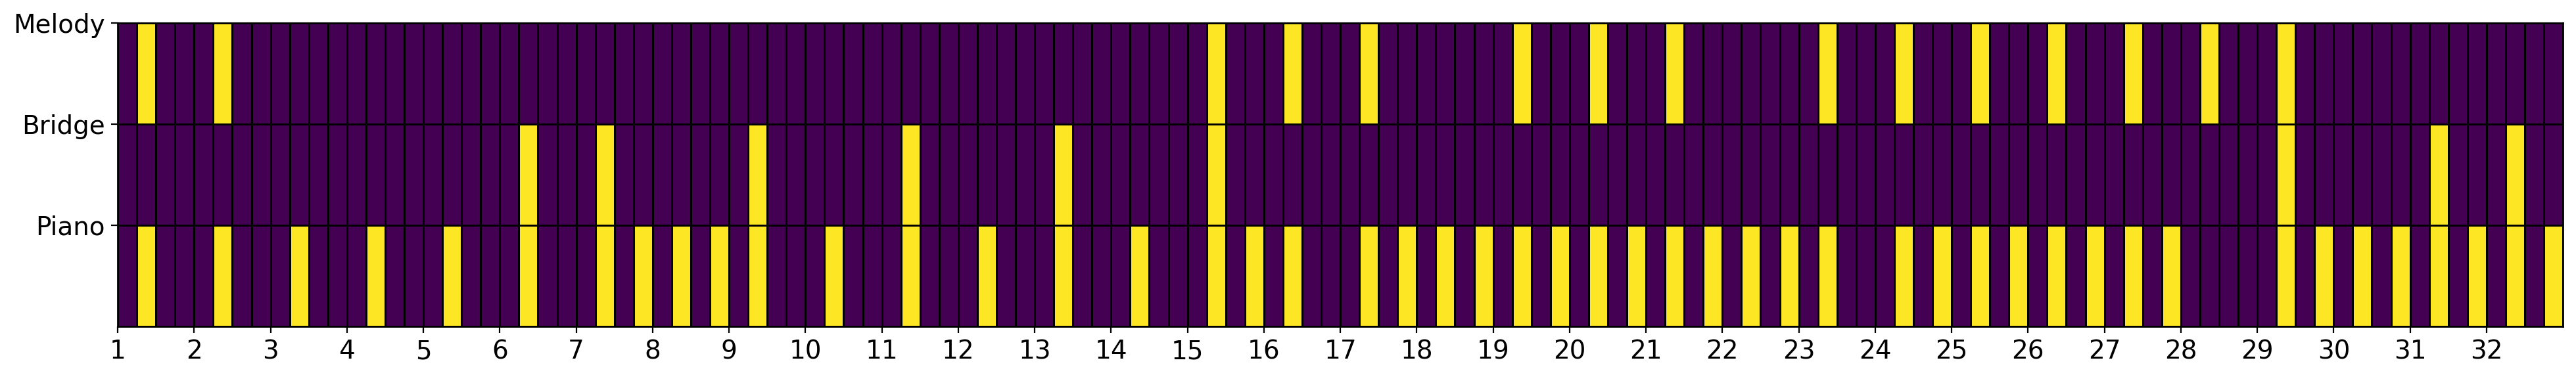

In [159]:
plot_structure((s_tensor==1).reshape(3, 8, -1).permute(1, 0, 2), "preprocessed_POP8_mask_drop_img/774_1")

In [87]:
sum(s_tensor[2]==1)

tensor(25)

In [94]:
s_tensor.reshape(-1).bool().sum()

tensor(422)

In [95]:
(s_tensor==1).reshape(-1).bool().sum()

tensor(38)

In [101]:
c_tensor[(s_tensor==1)].shape

torch.Size([38, 16, 2])

In [37]:
['hi']*3

['hi', 'hi', 'hi']

In [40]:
5//4

1

In [41]:
5%4

1

In [43]:
c_tensor.shape

torch.Size([3, 256, 16, 2])

In [45]:
c_tensor[0][0]

tensor([[128,  96],
        [129,  97],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98],
        [130,  98]])

In [172]:
structure_dir = "POP909_structure"
[f for f in os.listdir(structure_dir) if 
                     ((not f.startswith('.')) 
                      and os.path.isdir(os.path.join(structure_dir, f))
                     )
 
                    ]

['295',
 '183',
 '567',
 '176',
 '396',
 '508',
 '418',
 '356',
 '293',
 '426',
 '502',
 '405',
 '107',
 '416',
 '789',
 '887',
 '898',
 '855',
 '839',
 '458',
 '318',
 '772',
 '359',
 '697',
 '870',
 '169',
 '091',
 '315',
 '485',
 '019',
 '272',
 '605',
 '177',
 '394',
 '445',
 '060',
 '684',
 '495',
 '032',
 '294',
 '659',
 '680',
 '691',
 '681',
 '782',
 '730',
 '114',
 '251',
 '726',
 '793',
 '453',
 '531',
 '026',
 '894',
 '190',
 '146',
 '897',
 '214',
 '780',
 '399',
 '186',
 '444',
 '379',
 '514',
 '481',
 '303',
 '582',
 '413',
 '268',
 '134',
 '594',
 '004',
 '097',
 '121',
 '352',
 '112',
 '434',
 '544',
 '709',
 '761',
 '116',
 '011',
 '687',
 '208',
 '256',
 '131',
 '906',
 '523',
 '149',
 '583',
 '838',
 '848',
 '590',
 '834',
 '689',
 '647',
 '757',
 '877',
 '510',
 '704',
 '783',
 '270',
 '119',
 '734',
 '723',
 '530',
 '885',
 '632',
 '758',
 '180',
 '228',
 '825',
 '310',
 '543',
 '193',
 '450',
 '796',
 '006',
 '708',
 '667',
 '471',
 '203',
 '307',
 '673',
 '037',


In [173]:
len(os.listdir("preprocessed_structure"))

909

In [188]:
sample_path = os.path.join("preprocessed_structure", "0010.npz")
data = np.load(sample_path)
c_tensor = torch.tensor(data["c_tensor"], dtype=torch.long)
s_tensor = torch.tensor(data["s_tensor"], dtype=torch.int)

In [191]:
c_tensor[1]

tensor([[[12, 17],
         [13, 18],
         [14, 19]],

        [[12, 17],
         [ 1,  4],
         [13, 18]],

        [[12, 17],
         [ 2,  8],
         [13, 18]],

        [[12, 17],
         [ 1,  4],
         [13, 18]],

        [[12, 17],
         [ 1,  4],
         [13, 18]],

        [[12, 17],
         [13, 18],
         [14, 19]],

        [[12, 17],
         [ 2,  8],
         [13, 18]],

        [[12, 17],
         [ 1,  4],
         [13, 18]],

        [[12, 17],
         [ 1,  4],
         [13, 18]],

        [[12, 17],
         [13, 18],
         [14, 19]],

        [[12, 17],
         [13, 18],
         [14, 19]],

        [[12, 17],
         [ 1,  4],
         [13, 18]]])

In [190]:
s_tensor

tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]], dtype=torch.int32)